In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Data exploration

## 1.1 Imports

In [2]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

## 1.2 Load data

In [3]:
df = pd.read_csv("../../dataset/data.csv")

## 1.3 Inspect data

We inspect the data to understand its structure, types, and any potential issues.

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.nunique()

In [ ]:
df['label'].value_counts(normalize=True) * 100

# 2. Data cleaning

## 2.1 Reshape data

We will combine 3 columns (title, text and subject) into a single column. This is done to simplify the data structure and make it easier to work with. The new column will be called "combined_text". We will also drop the original columns (date, title, text and subject) after the reshaping process.

In [4]:
# We regroup the 3 columns into one
df['combined_text'] = df['title'] + ' ' + df['text'] + ' ' + df['subject']

In [5]:
# We drop the 3 columns
df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

## 2.2 Separate y and X

We will separate the target variable (y) from the features (X). The target variable is the "label" column, which indicates whether the news article is fake or real. The features are the combined text of the articles.

In [6]:
y = df['label']
X = df.drop(['label'], axis=1)['combined_text']

In [7]:
X.head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: combined_text, dtype: object

# 3. Text preprocessing

## 3.1 Train-test split

We will split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance.

In [8]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## 3.2 Pre-processing pipeline

In [9]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def pre_token_cleanup(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocessing_pipeline(text):
    # Pre-token cleaning
    text = pre_token_cleanup(text)
    
    # Tokenization
    tokens = word_tokenize(text, language="english")
    
    # Cleaning steps
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    return tokens

# 4. Vectorization (TF_IDF)

## 4.1 Instantiation

We will use the TF-IDF (Term Frequency-Inverse Document Frequency) method to convert the text data into numerical vectors. This method helps in representing the importance of each word in the document relative to the entire corpus.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity(x): return x # We don't want to change the data

# We create the TfidfVectorizer. No need for the stop words since we already removed them.
tfidf_vectorizer = TfidfVectorizer(
    analyzer=identity,
    min_df=0.01,
    max_df=0.9,
    ngram_range=(1, 4), # we use quadrigrams because we have a lot of words
)

## 4.2 Pre-process training data

In [11]:
X_train = X_train.apply(preprocessing_pipeline)

## 4.3 Fit the training data

In [12]:
# We fit the pre-processed training data
tfidf_vectorizer.fit(X_train)

/Users/joachimjasmin/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


TfidfVectorizer(analyzer=<function identity at 0x11555d580>, max_df=0.9,
                min_df=0.01, ngram_range=(1, 4))

## 4.4 Transform the training data

In [13]:
# We transform the training data to tfidf matrix
tfidf_vect_train = tfidf_vectorizer.transform(X_train)

## 4.5 Visualize the TF-IDF matrix

In [14]:
# Vectorizer viz

print("Final dictionary =>", len(tfidf_vectorizer.vocabulary_), "words")
print("Dictionary =>", tfidf_vectorizer.vocabulary_)
print("TF-IDF matrix shape =>", tfidf_vect_train.shape)

Final dictionary => 2504 words
Dictionary => {'break': 269, 'first': 891, 'charge': 363, 'file': 877, 'russia': 1941, 'investigation': 1169, 'special': 2095, 'counsel': 518, 'robert': 1925, 'mueller': 1440, 'appear': 129, 'turn': 2336, 'something': 2076, 'scandal': 1960, 'official': 1516, 'accord': 11, 'cnn': 410, 'someone': 2075, 'may': 1364, 'well': 2444, 'take': 2213, 'custody': 555, 'day': 573, 'house': 1074, 'senate': 1996, 'seem': 1991, 'throw': 2269, 'republican': 1871, 'include': 1115, 'trump': 2329, 'call': 308, 'hillary': 1049, 'one': 1525, 'still': 2138, 'exclusive': 809, 'story': 2144, 'currently': 554, 'order': 1542, 'federal': 863, 'judge': 1218, 'office': 1514, 'would': 2482, 'comment': 429, 'however': 1076, 'say': 1957, 'plan': 1635, 'prepared': 1684, 'friday': 937, 'anyone': 120, 'soon': 2079, 'monday': 1422, 'source': 2084, 'unclear': 2352, 'appoint': 133, 'shortly': 2035, 'fire': 889, 'fbi': 858, 'director': 652, 'james': 1193, 'comey': 426, 'original': 1546, 'whethe

In [15]:
# Vectorized train viz
tfidf_df_train = pd.DataFrame(tfidf_vect_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("Top 10 words : \n")
print(tfidf_df_train.sum().sort_values(ascending=False).head(10))

print("Last 10 words : \n")
print(tfidf_df_train.sum().sort_values(ascending=False).tail(10))

Top 10 words : 

trump         2769.955933
say           2200.876391
state         1067.175102
president     1057.609378
republican     953.082678
would          935.169532
clinton        855.432294
people         815.029248
house          780.009034
obama          777.954852
dtype: float64
Last 10 words : 

advanced       27.319439
stem           27.292183
fundamental    26.964393
sharp          26.841418
exclusive      26.519168
influential    26.484445
strain         26.452051
generate       26.133776
enable         26.107586
extent         24.913631
dtype: float64


# 5. Model training

## 5.1 Multinomial Naive Bayes Model

We will train a Multinomial Naive Bayes Model on the training data. This model is good for text classification tasks and works well with high-dimensional data like text.

### Train the model

In [16]:
# Instanciation of the model
naive_model = MultinomialNB()

### Fit the model on the training data

In [17]:
naive_model.fit(tfidf_vect_train, y_train)

MultinomialNB()

### Vectorize the test data

In [18]:
# Vectorization of the test set
tfidf_vect_test = tfidf_vectorizer.transform(X_test)

### Predict the test data

In [19]:
# Prediction
y_pred = naive_model.predict(tfidf_vect_test) # Prédit les labels sur les données de test

### Analysis - Confusion Matrix

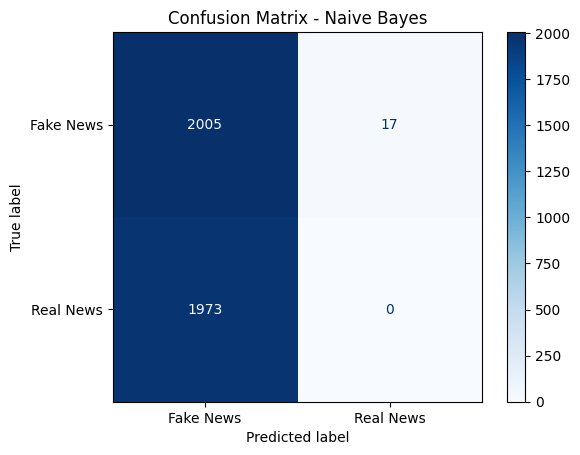

In [20]:
# Labels (1 = Real News, 0 = fake News)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### Analysis - ROC Curve

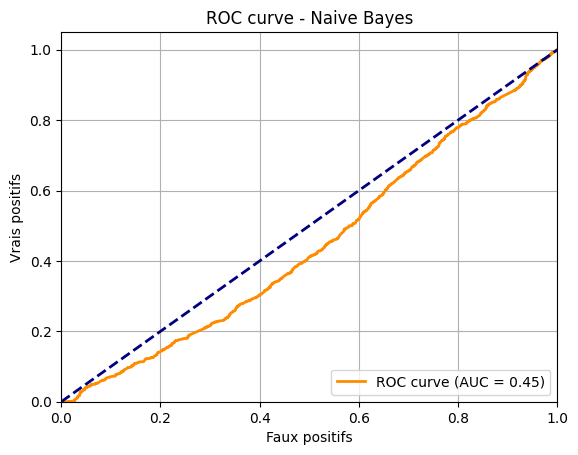

In [21]:
from sklearn.metrics import roc_curve, auc

y_proba = naive_model.predict_proba(tfidf_vect_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("ROC curve - Naive Bayes")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Analysis - Classification Report

In [22]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"]))

              precision    recall  f1-score   support

   Fake News       0.50      0.99      0.67      2022
   Real News       0.00      0.00      0.00      1973

    accuracy                           0.50      3995
   macro avg       0.25      0.50      0.33      3995
weighted avg       0.26      0.50      0.34      3995



### Analysis - Accuracy Score

In [23]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final accuracy : {accuracy:.4f}")

Final accuracy : 0.5019


# 6. Model saving

In [24]:
import pickle
import json

# Save the model
with open("../exports/naive_bayes_v1/nb_model_v1.pkl", "wb") as f:
    pickle.dump(naive_model, f)

# Save the TfidfVectorizer
with open("../exports/naive_bayes_v1/tfidf_vect_v1.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the metadata
metadata = {
    "model_name": "MultinomialNB_v1",
    "vectorizer": "TfidfVectorizer",
    "accuracy": round(accuracy, 4),
    "date": "2025-05-22",
    "preprocessing": {
        "tokenization": "nltk word_tokenize",
        "stopwords": "NLTK english",
        "lemmatization": "WordNet POS-aware",
        "lowercase": True,
        "remove_punctuation": True
    },
    "vectorizer_params": str(tfidf_vectorizer.get_params()),
    "model_params": str(naive_model.get_params())
}

with open("../exports/naive_bayes_v1/nb_meta_v1.json", "w") as f:
    json.dump(metadata, f, indent=4)

# 7. Model (re)loading

In [25]:
import pickle

# Load the model
with open("../exports/naive_bayes_v1/nb_model_v1.pkl", "rb") as f:
    nb_model = pickle.load(f)

# Load the TfidfVectorizer
with open("../exports/naive_bayes_v1/tfidf_vect_v1.pkl", "rb") as f:
    tfidf_vect = pickle.load(f)

# 8. Prediction

We use the trained model to make predictions on new data. The predictions will be in the form of probabilities for each class (fake or real). We will also provide a threshold to classify the articles as fake or real based on the predicted probabilities.

In [27]:
# Load val data
val_df = pd.read_csv("../../dataset/validation_data.csv")

# Pre-process the validation data
val_df['combined_text'] = val_df['title'] + ' ' + val_df['text'] + ' ' + val_df['subject']
val_df.drop(['label'], axis=1, inplace=True)

X_val = val_df['combined_text'].apply(preprocessing_pipeline)

# Vectorize the validation data
tfidf_vect_val = tfidf_vect.transform(X_val)

# Predict the labels
y_val_pred = nb_model.predict(tfidf_vect_val)

# Save the predictions
val_df['predicted_label'] = y_val_pred
val_df.to_csv("../data/validation_predictions_v1.csv", index=False)
print("Validation predictions saved to ../data/validation_predictions_v1.csv")

Validation predictions saved to ../data/validation_predictions_v1.csv
